# Tornado Synthetic Dataset - 3D Steady
> [cgl datasets](https://cgl.ethz.ch/research/visualization/data.php)

In [31]:
import numpy as np
import pyvista as pv
from scipy import interpolate
import matplotlib.pyplot as plt

In [32]:
file = '..\\Data\\tornado3d.vti'
mesh = pv.read(file)

## Baseline Streamlines

In [33]:
w,v,u = mesh.point_data['w'], mesh.point_data['v'], mesh.point_data['u']

vectors = np.empty((mesh.n_points, 3))
vectors[:,0] = u
vectors[:,1] = v
vectors[:,2] = w

mesh['vectors'] = vectors

stream1, seed_pts = mesh.streamlines(
    'vectors', 
    return_source=True,
    n_points=100,
    source_radius=10,
    source_center=(-4e-11,-4e-11,-4e-11)
)


## Compute Streams

In [34]:
def compute_streams(s, seeds, base_mesh):
    '''
        Computes streamlines from seed points and down sample size
    '''
    ws,vs,us = base_mesh.point_data['w'], base_mesh.point_data['v'], base_mesh.point_data['u']

    us.shape = vs.shape = ws.shape = base_mesh.dimensions


    # Down Sample / Decimate
    us = us[::s, ::s, ::s] 
    vs = vs[::s, ::s, ::s]
    ws = ws[::s, ::s, ::s]

    dims = us.shape
    print(f'Dimensions of Grid{s} : {dims}')

    us = us.flatten()
    vs = vs.flatten()
    ws = ws.flatten()

    vectorss = np.empty((int(len(us)), 3))
    vectorss[:,0] = us
    vectorss[:,1] = vs
    vectorss[:,2] = ws

    meshs = pv.UniformGrid(
        dims=dims,
        spacing=tuple([x*s for x in list(base_mesh.spacing)]),
        origin=base_mesh.origin
    )
    
    print(f'Mesh Spacing : {meshs.spacing}')

    meshs['vectorss'] = vectorss
    
    streams = meshs.streamlines_from_source(
        vectors='vectorss', 
        source=seeds
    )
    
    return streams, meshs


## Downsampled Streamlines

In [35]:
stream2, mesh2 = compute_streams(2, seed_pts, mesh)
stream4, mesh4 = compute_streams(4, seed_pts, mesh)
stream8, mesh8 = compute_streams(8, seed_pts, mesh)
stream16, mesh16 = compute_streams(16, seed_pts, mesh)
stream32, mesh32 = compute_streams(32, seed_pts, mesh)

Dimensions of Grid2 : (64, 64, 64)
Mesh Spacing : (0.31496062992, 0.31496062992, 0.31496062992)
Dimensions of Grid4 : (32, 32, 32)
Mesh Spacing : (0.62992125984, 0.62992125984, 0.62992125984)
Dimensions of Grid8 : (16, 16, 16)
Mesh Spacing : (1.25984251968, 1.25984251968, 1.25984251968)
Dimensions of Grid16 : (8, 8, 8)
Mesh Spacing : (2.51968503936, 2.51968503936, 2.51968503936)
Dimensions of Grid32 : (4, 4, 4)
Mesh Spacing : (5.03937007872, 5.03937007872, 5.03937007872)


## Plotted Streamlines

In [36]:
def plot_streamlines(streams, boundary, sargs):
    p = pv.Plotter()
    p.add_mesh(streams.tube(radius=0.02), lighting=False, scalar_bar_args=sargs)
    p.add_mesh(boundary, color='grey', opacity=.25)
    p.show()

In [37]:
sargs=dict(vertical=True, title_font_size=16)
boundary1 = mesh2.decimate_boundary().extract_all_edges()
plot_streamlines(stream1, boundary1, sargs)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [38]:
sargs2=dict(vertical=True, title_font_size=16)
boundary2 = mesh2.decimate_boundary().extract_all_edges()
plot_streamlines(stream2, boundary2, sargs2)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [39]:
sargs4=dict(vertical=True, title_font_size=16)
boundary4 = mesh4.decimate_boundary().extract_all_edges()
plot_streamlines(stream4, boundary4, sargs4)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [40]:
sargs8=dict(vertical=True, title_font_size=16)
boundary8 = mesh8.decimate_boundary().extract_all_edges()
plot_streamlines(stream8, boundary8, sargs8)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [41]:
sargs16=dict(vertical=True, title_font_size=16)
boundary16 = mesh16.decimate_boundary().extract_all_edges()
plot_streamlines(stream16, boundary16, sargs16)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [42]:
sargs32=dict(vertical=True, title_font_size=16)
boundary32 = mesh32.decimate_boundary().extract_all_edges()
plot_streamlines(stream32, boundary32, sargs32)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

## Compute Errors

In [43]:
def compute_errors_helper(s1, s2):
    # Distance between each point in streamline
    dv_1 = s1[1:,:] - s1[:-1,:]
    dv_2 = s2[1:,:] - s2[:-1,:]

    # Length / Magnitude of each delta t
    dl_1 = np.sqrt(np.sum(dv_1**2, axis=1))
    dl_2 = np.sqrt(np.sum(dv_2**2, axis=1))

    t1 = np.r_[0, np.cumsum(dl_1)]
    t2 = np.r_[0, np.cumsum(dl_2)]

    # Lengths of streamline
    length_1 = t1[-1]
    length_2 = t2[-1]

    x1 = interpolate.interp1d(t1, s1[:,0])
    y1 = interpolate.interp1d(t1, s1[:,1])
    z1 = interpolate.interp1d(t1, s1[:,2])
    p1 = lambda t : np.c_[x1(t), y1(t), z1(t)]

    x2 = interpolate.interp1d(t2, s2[:,0])
    y2 = interpolate.interp1d(t2, s2[:,1])
    z2 = interpolate.interp1d(t2, s2[:,2])
    p2 = lambda t : np.c_[x2(t), y2(t), z2(t)]

    t = np.linspace(0, min(length_1, length_2), 11)    
    ind_error = np.linalg.norm(p1(t) - p2(t), axis=1) # Same as magnitude
    tot_error = np.sum(ind_error)
    rms_error = np.sqrt(np.mean(ind_error**2))
    
    return t, ind_error, tot_error, rms_error
    

In [44]:
def compute_errors(streams_base, streams_sampled):
    ind_errors = []
    tot_errors = []
    rms_errors = []
    
    streams_1 = streams_base.copy()
    streams_2 = streams_sampled.copy()
    
    for i in range(streams_2.n_cells):          
        stream_2 = streams_2.cell_points(i)
        for j in range(streams_1.n_cells):   
            stream_1 = streams_1.cell_points(j)
        
            if(stream_1[0][0] == stream_2[0][0]):
                streams_1 = streams_1.remove_cells(j)  
                t, ind_error, tot_error, rms_error = compute_errors_helper(stream_1, stream_2)
                ind_errors.append(ind_error)
                tot_errors.append(tot_error)
                rms_errors.append(rms_error)
                break
    
    return t, ind_errors, tot_errors, rms_errors

In [45]:
t2, ind_errors2, tot_errors2, rms_errors2 = compute_errors(stream1, stream2)
t4, ind_errors4, tot_errors4, rms_errors4 = compute_errors(stream1, stream4)
t8, ind_errors8, tot_errors8, rms_errors8 = compute_errors(stream1, stream8)
t16, ind_errors16, tot_errors16, rms_error16 = compute_errors(stream1, stream16)
t32, ind_errors32, tot_errors32, rms_error32 = compute_errors(stream1, stream32)

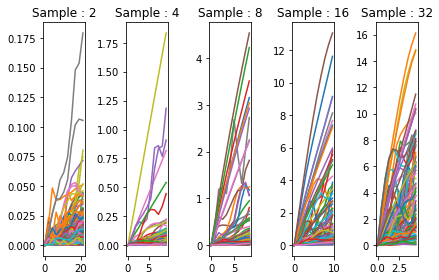

In [57]:
# Plot of each streamlines error as it grows in comparison to the base

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5)

ax1.set_title('Sample : 2')
ax2.set_title('Sample : 4')
ax3.set_title('Sample : 8')
ax4.set_title('Sample : 16')
ax5.set_title('Sample : 32')

for i in range(len(ind_errors2)):
    ax1.plot(t2, ind_errors2[i], label="error {i}")
    
for i in range(len(ind_errors4)):
    ax2.plot(t4, ind_errors4[i], label="error {i}")
    
for i in range(len(ind_errors8)):
    ax3.plot(t8, ind_errors8[i], label="error {i}")
    
for i in range(len(ind_errors16)):
    ax4.plot(t16, ind_errors16[i], label="error {i}")   
    
for i in range(len(ind_errors32)):
    ax5.plot(t32, ind_errors32[i], label="error {i}") 
fig.tight_layout()
plt.show()

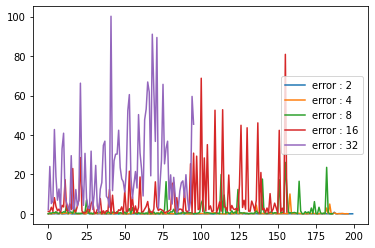

In [47]:
# Total error for each streamline plotted from streamline 0 - #ofStreamlines

plt.plot(tot_errors2, label='error : 2')
plt.plot(tot_errors4, label='error : 4')
plt.plot(tot_errors8, label='error : 8')
plt.plot(tot_errors16, label='error : 16')
plt.plot(tot_errors32, label='error : 32')
plt.legend()
plt.show()

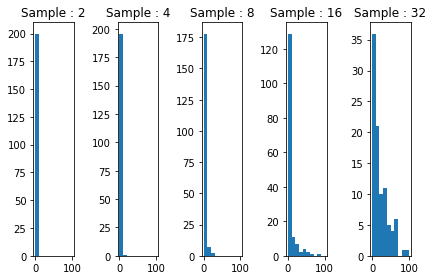

In [63]:
r = (0, 100)
bins = 10

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5)

ax1.set_title('Sample : 2')
ax2.set_title('Sample : 4')
ax3.set_title('Sample : 8')
ax4.set_title('Sample : 16')
ax5.set_title('Sample : 32')

n2, bins2, patches2 = ax1.hist(x=tot_errors2, bins=bins, range=r)
n4, bins4, patches4 = ax2.hist(x=tot_errors4, bins=bins, range=r)
n8, bins8, patches8 = ax3.hist(x=tot_errors8, bins=bins, range=r)
n16, bins16, patches16 = ax4.hist(x=tot_errors16, bins=bins, range=r)
n32, bins32, patches32 = ax5.hist(x=tot_errors32, bins=bins, range=r)
fig.tight_layout()
plt.show()